# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import h5py

# Pre-Trained Word2Vector

In [2]:
vocab_size = 65908
embedding_dim = 100
max_sequence_length = 100

In [3]:
df_data = pd.read_csv('data/data_hasil_prepos.csv')

df_data.head()

,statement,status,translated_statement,jumlah_kata
0,oh my gosh,Anxiety,ampun,2
1,"trouble sleeping, confused mind, restless hear...",Anxiety,susah tidur pikir kacau hati gelisah semua tak...,9
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,semua salah mundur lah sayang maju ragu tetapl...,15
3,I've shifted my focus to something else but I'...,Anxiety,alih fokusku khawatir,10
4,"I'm restless and restless, it's been a month n...",Anxiety,gelisah gelisah sebul nak maksudmu,10


In [4]:
from nltk.tokenize import word_tokenize

df_data['tokenized'] = df_data['translated_statement'].astype(str).apply(word_tokenize)

In [5]:
sentences = df_data['tokenized'].tolist()

In [6]:
# Latih model Word2Vec
from gensim.models import Word2Vec

word2vec_model = Word2Vec(sentences, 
                          vector_size=max_sequence_length, 
                          window=10, 
                          min_count=1, 
                          workers=4)

In [7]:
# Simpan Word2Vec model
word2vec_model.save("model_word2vec/word2vec_model_MentalQ.model")

# Simpan embedding ke file .h5
save_h5 = "model_word2vec/word2vec_model_MentalQ.h5"

with h5py.File(save_h5, "w") as h5file:
    h5file.create_dataset("vocab", data=word2vec_model.wv.index_to_key, dtype=h5py.string_dtype(encoding='utf-8'))
    h5file.create_dataset("vectors", data=word2vec_model.wv.vectors)

In [8]:
# Buat word_index dari Word2Vec
word_index = {word: i + 1 for i, word in enumerate(word2vec_model.wv.index_to_key)}

# Buat embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = word2vec_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [9]:
# Fungsi untuk mengonversi token menjadi indeks
def text_to_sequence(tokens, word_index):
    return [word_index[word] for word in tokens if word in word_index]

# Ubah kolom 'tokenized' menjadi sequence
df_data['sequence'] = df_data['tokenized'].apply(lambda x: text_to_sequence(x, word_index))

In [10]:
# Padding sequence agar semua memiliki panjang yang sama
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequence = pad_sequences(df_data['sequence'], maxlen=max_sequence_length, padding='post')
print(padded_sequence)

[[1047    0    0 ...    0    0    0]
 [1203   36   11 ...    0    0    0]
 [   9   64 1305 ...    0    0    0]
 ...
 [  33  187  743 ...    0    0    0]
 [ 250  275   33 ...    0    0    0]
 [  47   10  146 ...    0    0    0]]


In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
status_encoded = label_encoder.fit_transform(df_data['status'])
print(status_encoded)

[0 0 0 ... 0 0 0]


In [12]:
print("label:", label_encoder.classes_)

for encoded_value, class_label in zip(range(len(label_encoder.classes_)), label_encoder.classes_):
    print(f"Encoded value {encoded_value} -> label '{class_label}'")

label: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
Encoded value 0 -> label 'Anxiety'
Encoded value 1 -> label 'Bipolar'
Encoded value 2 -> label 'Depression'
Encoded value 3 -> label 'Normal'
Encoded value 4 -> label 'Personality disorder'
Encoded value 5 -> label 'Stress'
Encoded value 6 -> label 'Suicidal'


# Data Preparation

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequence,
                                                    status_encoded,
                                                    test_size=0.2,
                                                    random_state=60,
                                                    stratify=status_encoded
                                                    )

In [14]:
print(f'X train: {X_train.shape}\n{X_train}\n')
print(f'X test: {X_test.shape}\n{X_test}\n')
print(f'y train: {y_train.shape}\n{y_train}\n')
print(f'y test: {y_test.shape}\n{y_test}')

X train: (28230, 100)
[[1761  126  969 ...    0    0    0]
 [  52  217 5926 ...    0    0    0]
 [ 267   22  511 ...    0    0    0]
 ...
 [ 294    0    0 ...    0    0    0]
 [ 115  231   25 ...    0    0    0]
 [ 221  221  318 ...    0    0    0]]

X test: (7058, 100)
[[  394 22294   358 ...     0     0     0]
 [   10    18   315 ...     0     0     0]
 [ 1934   316    29 ...     0     0     0]
 ...
 [14675   941     0 ...     0     0     0]
 [ 1709  3030   980 ...     0     0     0]
 [  227   961    39 ...     0     0     0]]

y train: (28230,)
[3 3 6 ... 3 2 3]

y test: (7058,)
[5 6 2 ... 3 2 5]


In [15]:
# Data distribusi di dataset awal
print("Distribusi dataset awal:")
print(pd.Series(status_encoded).value_counts(normalize=True))

# Data distribusi di training set
print("\nDistribusi di training set:")
print(pd.Series(y_train).value_counts(normalize=True))

# Data distribusi di testing set
print("\nDistribusi di testing set:")
print(pd.Series(y_test).value_counts(normalize=True))

Distribusi dataset awal:
3    0.449756
2    0.224439
6    0.182215
0    0.055940
5    0.046021
1    0.030237
4    0.011392
Name: proportion, dtype: float64

Distribusi di training set:
3    0.449770
2    0.224442
6    0.182217
0    0.055933
5    0.046015
1    0.030216
4    0.011406
Name: proportion, dtype: float64

Distribusi di testing set:
3    0.449702
2    0.224426
6    0.182205
0    0.055965
5    0.046047
1    0.030320
4    0.011335
Name: proportion, dtype: float64


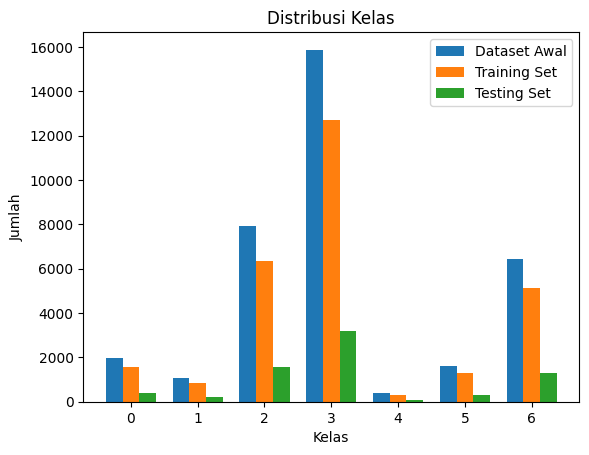

In [16]:
# Hitung distribusi kelas
classes, counts_full = np.unique(status_encoded, return_counts=True)
_, counts_train = np.unique(y_train, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

# Plot distribusi
bar_width = 0.25
x = np.arange(len(classes))

plt.bar(x - bar_width, counts_full, width=bar_width, label="Dataset Awal")
plt.bar(x, counts_train, width=bar_width, label="Training Set")
plt.bar(x + bar_width, counts_test, width=bar_width, label="Testing Set")

plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.title("Distribusi Kelas")
plt.xticks(x, classes)
plt.legend()
plt.show()

# Modeling

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [18]:
def create_model():
    model = Sequential([
        # Embedding Layer
        Embedding(input_dim=len(word_index) + 1, 
                  output_dim=embedding_dim, 
                  weights=[embedding_matrix], 
                  input_length=max_sequence_length, 
                  trainable=True),

        # Bidirectional LSTM Layer
        Bidirectional(LSTM(192,
                           kernel_regularizer=l2(0.005),
                           return_sequences=False)),
        Dropout(0.35),
        BatchNormalization(),
        
        # Dense Layer 1
        Dense(48, activation='tanh'),
        Dropout(0.5),
        BatchNormalization(),
        
        # Dense Layer 2
        Dense(40, activation='tanh'),
        Dropout(0.3),
        BatchNormalization(),
        
        # Output Layer
        Dense(7, activation='softmax')
    ])

    # Compile model dengan learning rate yang ditemukan oleh tuner
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [19]:
# Callback akurasi 98%
class SimpleEarlyStopping(Callback):
    def __init__(self, target=0.98):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.target:
            print(f"\nTarget val_accuracy = {self.target} tercapai pada epoch {epoch+1}. Training dihentikan.")
            self.model.stop_training = True

In [20]:
# Callbacks
early_stopping_accuracy = SimpleEarlyStopping(target=0.98)

early_stopping_overfitting = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Hitung class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [21]:
model = create_model()

c:\Users\RafiAchmadfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Train & Evaluasi Model

In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    callbacks=[reduce_lr],
    class_weight=class_weights
)

Epoch 1/25
883/883 ━━━━━━━━━━━━━━━━━━━━ 124s 128ms/step - accuracy: 0.2899 - loss: 3.4988 - val_accuracy: 0.5300 - val_loss: 2.2109 - learning_rate: 1.0000e-04
Epoch 2/25
883/883 ━━━━━━━━━━━━━━━━━━━━ 111s 126ms/step - accuracy: 0.4483 - loss: 2.5441 - val_accuracy: 0.5679 - val_loss: 1.9472 - learning_rate: 1.0000e-04
Epoch 3/25
883/883 ━━━━━━━━━━━━━━━━━━━━ 119s 135ms/step - accuracy: 0.4895 - loss: 2.2769 - val_accuracy: 0.5781 - val_loss: 1.7764 - learning_rate: 1.0000e-04
Epoch 4/25
883/883 ━━━━━━━━━━━━━━━━━━━━ 115s 131ms/step - accuracy: 0.5103 - loss: 2.0734 - val_accuracy: 0.5803 - val_loss: 1.6885 - learning_rate: 1.0000e-04
Epoch 5/25
883/883 ━━━━━━━━━━━━━━━━━━━━ 115s 130ms/step - accuracy: 0.5249 - loss: 1.9317 - val_accuracy: 0.5772 - val_loss: 1.6101 - learning_rate: 1.0000e-04
Epoch 6/25
883/883 ━━━━━━━━━━━━━━━━━━━━ 117s 132ms/step - accuracy: 0.5397 - loss: 1.8424 - val_accuracy: 0.5754 - val_loss: 1.5709 - learning_rate: 1.0000e-04
Epoch 7/25
883/883 ━━━━━━━━━━━━━━━━━━━━ 

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     2,791,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 384)            │       450,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │        18,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         1,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           287 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,790,903 (37.35 MB)

 Trainable params: 3,263,319 (12.45 MB)

 Non-trainable params: 944 (3.69 KB)

 Optimizer params: 6,526,640 (24.90 MB)

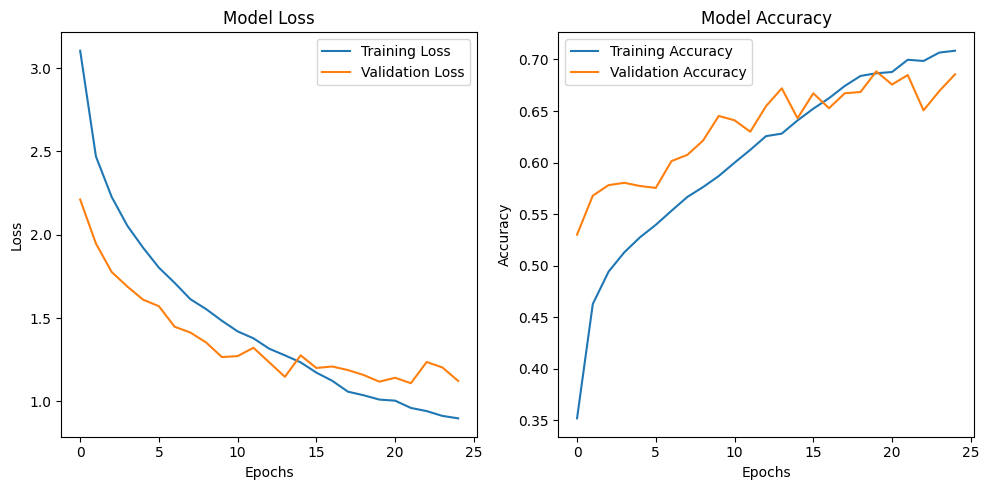

In [27]:
import matplotlib.pyplot as plt

ig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Menampilkan subplot
plt.tight_layout()
plt.show()

In [28]:
model.save('model_lstm/ml_model.h5')